Есть данные о работе склада -  автоматический сбор конвейером заказанной покупателями номенклатуры  в ячейку для отправки в экспедиию. Ячейка соответствует одному транспортному направлению, по которому поедет водитель развозить заказы.

Проектируем новую обработку заказанного товара - объединение заказов по адресу доставки, до сих пор это делала водитель и тратил 3 часа рабочего времени для рассортировки пакетов по адресам доставки, чтобы несколько заказов на один адрес лежали в одном пакете.

Хотим понять, как отличаются между собой дни недели по количеству заказов и времени готовности к отправке покупателям, чтобы планировать работу сотрудниковв по дням недели и времени выхода на работу.


In [ ]:
#основные библиотеки
import numpy as np
import pandas as pd
#для визуализации пропусков
import missingno as msno
#для работы с датами
from datetime import datetime, timedelta
from datetime import datetime
#для рисовния графиков
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#подсчет моды как статистики
from scipy import stats
#не показывать предупреждения системы о ближайших изменениях библиотек
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('ДАННЫЕ.xlsx')
df1 = pd.read_excel('ВСЕ_АДТ.xlsx')
df = df.merge(df1, how = 'inner')
df.head(2)

,ЗПК.СхемаПродаж,ЗПК.Дата,ЗПК.НомерДокумента,ЗПК.ДатаОтгрузки,ЗПК.СтатусДоставлен,ДатаЗНС,НомерДокументаЗНС,Сборка.ДатаАП,Сборка.НомерАП,ДС.ВремяКОтбору,...,Экспедиция.ДатаАП,Экспедиция.НомерАП,ДС.ВремяКРазмещениюВЭкспедиции,ДС.ВремяРазмещеноВЭкспедиции,Экспедиция.Ячейка,ВремяРазместитьВЭкспедицииДо,ВремяЗавершитьСборкуДо,ЗПК.КодГрузополучателяТООригинал,ЗПК.НаименованиеНаправления,Адрес
0,Коммерция (обычный заказ),2024-06-01,МСК10143329,2024-06-03,Доставлен,2024-06-02,МСК010618387,2024-06-02,76470974,2024-06-02 12:56:10,...,2024-06-02,76497565,2024-06-02 18:01:14,2024-06-02 18:17:00,09-08-449-1,06:00:00,05:30:00,МСК000246330,Обл Калуж Московский,"108811, г. Москва, поселение Московский, ул. С..."
1,Коммерция (обычный заказ),2024-06-03,МСК10193150,2024-06-06,Доставлен,2024-06-05,МСК010677689,2024-06-05,76697475,2024-06-05 13:53:09,...,2024-06-05,76720991,2024-06-05 16:52:45,2024-06-05 17:52:40,09-08-449-1,06:00:00,05:30:00,МСК000246330,Обл Калуж Московский,"108811, г. Москва, поселение Московский, ул. С..."


<Axes: >

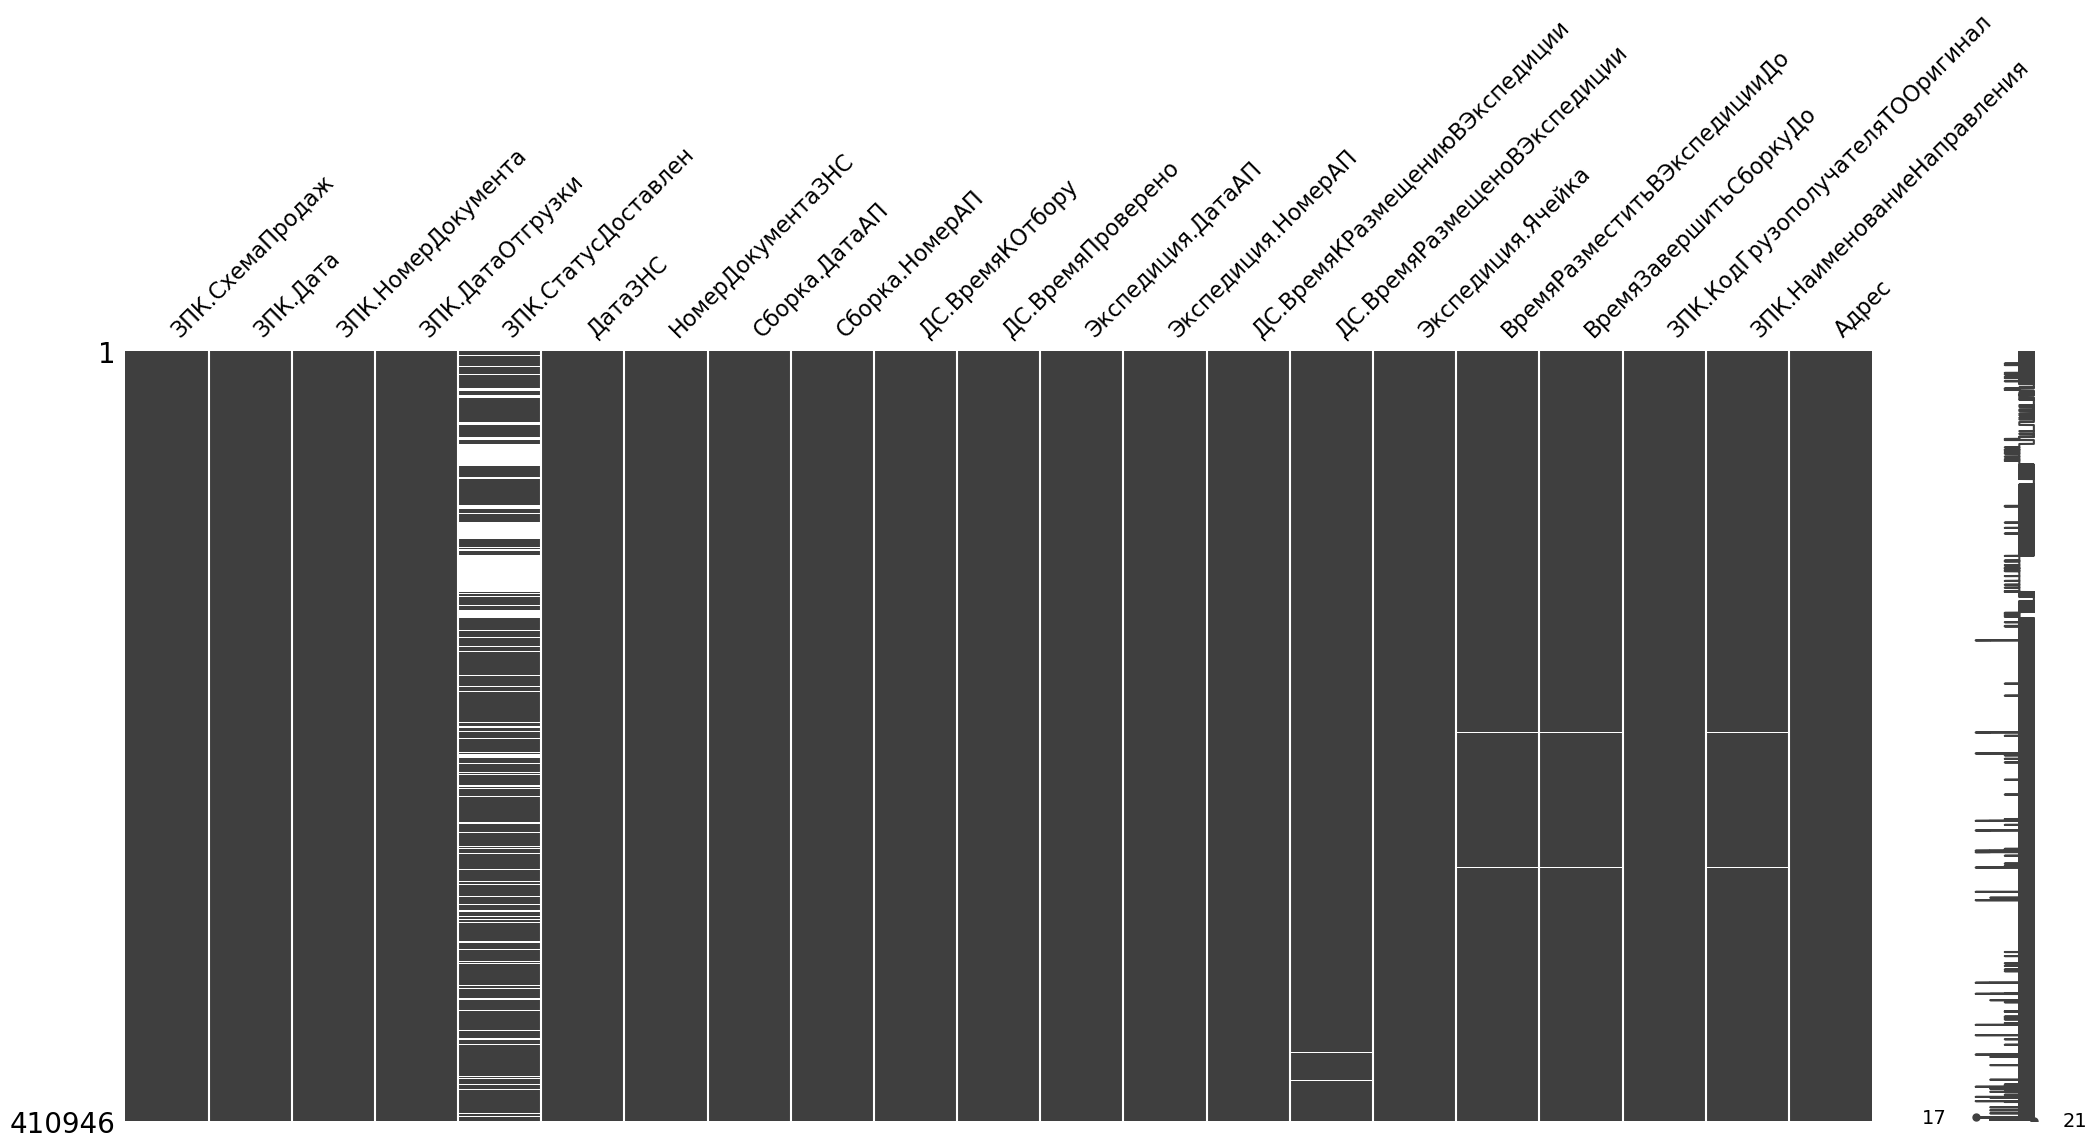

In [ ]:
#визуализация пропусков
msno.matrix(df)

Для исследования данных удалю строки с пустыми ячейками, оставлю только нужные столбцы.


In [ ]:
#нулевой фрейм для исследования  данных
df0 = df.copy().dropna()[['ЗПК.СхемаПродаж',
                          'Экспедиция.НомерАП',
                          'ДС.ВремяРазмещеноВЭкспедиции',
                          'Экспедиция.Ячейка',
                          'ВремяЗавершитьСборкуДо',
                          'Адрес'
                         ]]
df0 = df0[ (df0['Экспедиция.Ячейка'] != 'До выяснения')
          & (df0['Экспедиция.Ячейка'] != 'Отказ клиента')
           & (df0['Экспедиция.Ячейка'] != 'Ошибка Конвейер')
            & (df0['ЗПК.СхемаПродаж'] != 'Электронная коммерция (agent)')]

df0 = df0.sort_values(by = ['ЗПК.СхемаПродаж','Адрес','Экспедиция.Ячейка','ДС.ВремяРазмещеноВЭкспедиции','ВремяЗавершитьСборкуДо'])
df0.head(1)

,ЗПК.СхемаПродаж,Экспедиция.НомерАП,ДС.ВремяРазмещеноВЭкспедиции,Экспедиция.Ячейка,ВремяЗавершитьСборкуДо,Адрес
339245,Goods forecast,76679880,2024-06-05 07:26:04,09-05-134-1,03:00:00,"241035, Брянская обл, г Брянск, ул Сталелитейн..."


Фактическое время нужно перевести в часы работы склада, где 8 часов утра - это первый час складсих суток и 7 часов - это 24 и последний час складских суток.
Время работы склада переввожу в минуты.


In [ ]:
#Пересчитываю дни и часы в режим работы склада

#Считываю фактические дни часы минуты
df0['День'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.to_period("D")
df0['Время'] = df0['ДС.ВремяРазмещеноВЭкспедиции'].dt.to_period("MIN")
df0['Час'] = df0['Время'].dt.hour.astype(int)
df0['Минуты'] = df0['Время'].dt.minute.astype(int)
df0['ДеньНедели'] = df0['День'].dt.strftime("%A")

#считаю предыдущий день и время по схеме работы с клада с 8 до 7 часов
df0['День-'] = (df0['ДС.ВремяРазмещеноВЭкспедиции'] - pd.Timedelta("1 day")).dt.to_period("D")
df0['ДеньНедели-'] = df0['День-'].dt.strftime("%A")

#пересчитываю время работы склада (8 первый час работы склада, 7  - 24й час работы склада)
df0['ВремяСклада'] = np.where(df0['Час'] >= 8, df0['ДС.ВремяРазмещеноВЭкспедиции'] - pd.Timedelta("7 hours"),
                                               df0['ДС.ВремяРазмещеноВЭкспедиции'] + pd.Timedelta("17 hours"))

#также нужна замена дня и дня недели если фактическое время раньше 8, тк это окончание прошлых суток работы склада
df0['ДеньCклада'] = np.where(df0['Час'] >= 8, df0['День'], df0['День-'])
df0['ДеньНеделиCклада'] = np.where(df0['Час'] >= 8, df0['ДеньНедели'], df0['ДеньНедели-'])
df0['ЧасСклада'] = np.where(df0['Час'] >= 8, df0['Час'] - 7, df0['Час'] + 17)
df0['ПоминутноеВремяСклада'] = df0['ЧасСклада'] * 60 + df0['Минуты']

# #считываю время заверешения сборки до минут
df0['ВремяЗавершитьСборкуДоЧас'] = df0['ВремяЗавершитьСборкуДо'].astype(str).str.split(':').str[0].astype (int)
df0['ВремяЗавершитьСборкуДоМин'] = df0['ВремяЗавершитьСборкуДо'].astype(str).str.split(':').str[1].astype (int)
# # #перевожу время завершения сборки в складское время по той же схеме
df0['ВремяЗавершитьСборкуСкладЧас'] = np.where(df0['ВремяЗавершитьСборкуДоЧас'] >= 8,
                                           df0['ВремяЗавершитьСборкуДоЧас'] - 7,
                                           df0['ВремяЗавершитьСборкуДоЧас'] + 17)

df0['ПоминутноеВремяЗавершенияСклада'] = df0['ВремяЗавершитьСборкуСкладЧас'] * 60 + df0['ВремяЗавершитьСборкуДоМин']

#оставляю только нужные ячейки
df0 = df0[['ЗПК.СхемаПродаж',
           'Экспедиция.НомерАП',
           'Экспедиция.Ячейка',
           'Адрес',
           'ДеньCклада',
           'ДеньНеделиCклада',
           'ЧасСклада',
           'ПоминутноеВремяСклада',
           'ПоминутноеВремяЗавершенияСклада']]

df0[(df0['Экспедиция.Ячейка'] == '09-05-002-1')].tail(2)

,ЗПК.СхемаПродаж,Экспедиция.НомерАП,Экспедиция.Ячейка,Адрес,ДеньCклада,ДеньНеделиCклада,ЧасСклада,ПоминутноеВремяСклада,ПоминутноеВремяЗавершенияСклада
341939,Коммерция (обычный заказ),78477721,09-05-002-1,"150066, Ярославская обл, Ярославль г, 1-я Техн...",2024-07-03,Wednesday,23,1403,1200
341940,Коммерция (обычный заказ),78474741,09-05-002-1,"150066, Ярославская обл, Ярославль г, 1-я Техн...",2024-07-03,Wednesday,23,1403,1200


Посчитаем как заполняется ячейка в течение складских суток.
В ячейке находится товар для отправки в экспедиию по разным адресам.
Полная заполненность адреса значит, что  ячейке находятся все товары предназначенные к отправке на этот адрес.
Полная заполненность ячейки означает, что в ячейку больше не будут поступать товары для отправки по разным адресам в течение складских суток.



In [ ]:
#считаю количество АП в ячейке накопительным итогом с учетом адреса
columns_adress = ['ЗПК.СхемаПродаж','Адрес','Экспедиция.Ячейка','ДеньCклада']

df0['КвоАП_Адрес'] = df0.groupby(columns_adress)['Экспедиция.НомерАП'].transform('count')
df0['КвоАП_АдресНакопительно'] = df0.groupby(columns_adress)['ПоминутноеВремяСклада'].transform('cumcount')
df0['КвоАП_АдресНакопительно'] += 1
df0['ЗаполненностьАдреса'] = df0['КвоАП_АдресНакопительно'] / df0['КвоАП_Адрес']

#считаю заполненность ячейки АП без учета адреса
columns = ['ЗПК.СхемаПродаж','Экспедиция.Ячейка','ДеньCклада']

df0['КвоАП_Ячейка'] = df0.groupby(columns)['Экспедиция.НомерАП'].transform('count')
df0['КвоАП_ЯчейкаНакопительно'] = df0.groupby(columns)['ПоминутноеВремяСклада'].transform('cumcount')
df0['КвоАП_ЯчейкаНакопительно'] += 1
df0['ЗаполненностьЯчейки'] = df0['КвоАП_ЯчейкаНакопительно'] / df0['КвоАП_Ячейка']


Как часто встречаются ячейки с количеством номенклатур на один адрес больше 0, больше 2, больше 3, больше 10 и больше 100?
Результат вывожу в % от общего количества случаев за весь период данных

In [ ]:
#делю заполненность ячейки количеством АП на интервалы
cut_labels = ['0+', '2+', '3+','10+','100+' ]
cut_bins = [0, 2, 3, 10, 100, df0['КвоАП_Адрес'].max()]

df0['Интервал'] = pd.cut(df0['КвоАП_Адрес'],
                           bins=cut_bins,
                           labels=cut_labels)

df0['Интервал'].value_counts(normalize = True)

Интервал
0+      0.449818
3+      0.354754
2+      0.139032
10+     0.050713
100+    0.005683
Name: proportion, dtype: float64

В какой день недели происходит отправка на высоконагруженные адреса, где более 100 покупок на один адрес?

In [ ]:
#Мода попадания в интервал заполненности по количеству АП - дни недели
df0.groupby('Интервал')['ДеньНеделиCклада'].agg(pd.Series.mode)

Интервал
0+      Monday
2+      Monday
3+      Sunday
10+     Monday
100+    Sunday
Name: ДеньНеделиCклада, dtype: object

Какая схема продаж соответствует высоконагруженным отправкам? Более 100 номенклатур на адрес

In [ ]:
#Мода попадания в интервал заполненности по количеству АП - схема продаж
df0.groupby('Интервал')['ЗПК.СхемаПродаж'].agg(pd.Series.mode)

Интервал
0+      Электронная коммерция (e-com)
2+      Электронная коммерция (e-com)
3+      Электронная коммерция (e-com)
10+     Электронная коммерция (e-com)
100+      Курьерская доставка (e-com)
Name: ЗПК.СхемаПродаж, dtype: object

Нужна подробноая информация о количестве АП на адрес доставки с детализацией по схемам продаж

In [ ]:
#удаляю столбец Интервал из датасета, он больше не нужен
df0.drop('Интервал', axis= 1 , inplace= True )
#строю агрегацию по всем соновным статистикам
agg_func_describe = {'КвоАП_Адрес': ['describe']}
df0.groupby(['ЗПК.СхемаПродаж']).agg(agg_func_describe).round(2)

КвоАП_Адрес                                  \
                                 describe                                   
                                    count   mean    std   min   25%   50%   
ЗПК.СхемаПродаж                                                             
Goods forecast                      349.0  40.34  10.96   5.0  38.0  39.0   
Коммерция (обычный заказ)         55980.0   4.06  10.20   1.0   1.0   1.0   
Курьерская доставка (e-com)        2307.0  94.70  31.51  48.0  70.0  88.0   
Электронная коммерция (e-com)    191774.0   4.44   6.68   1.0   2.0   3.0   

                                             
                                             
                                 75%    max  
ЗПК.СхемаПродаж                              
Goods forecast                  44.0   59.0  
Коммерция (обычный заказ)        2.0  102.0  
Курьерская доставка (e-com)    103.0  167.0  
Электронная коммерция (e-com)    5.0  118.0

Есть различия между днями недели по заполненности ячеек?
Может быть в некоторые дни недели заполнение более интенсивное?
Интенсивность - это количесто номенклатур на адрес доставки.

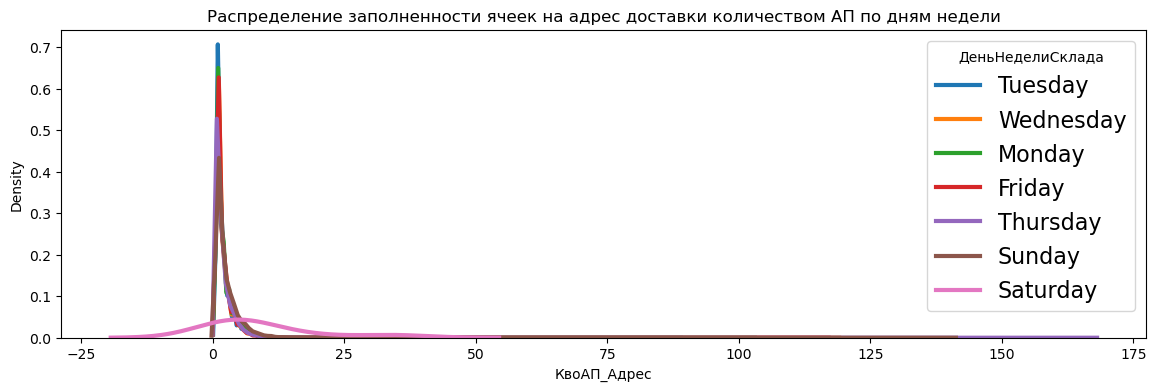

In [ ]:
df_week = df0.groupby(['ЗПК.СхемаПродаж',
                       'Адрес',
                       'Экспедиция.Ячейка',
                       'ДеньCклада',
                       'ДеньНеделиCклада'])['КвоАП_Адрес'].mean().reset_index()
#Распределение заполненности ячейки по КОЛИЧЕСТВУ АП в зависимости от дня недели
week_day = list(df0['ДеньНеделиCклада'].unique())
plt.figure(figsize=(14, 4))
for day in week_day:
    subset = df_week[df_week['ДеньНеделиCклада'] == day]
    sns.distplot(subset['КвоАП_Адрес'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = day)

#формат графика
plt.legend(prop={'size': 16}, title = 'ДеньНеделиСклада')
plt.title('Распределение заполненности ячеек на адрес доставки количеством АП по дням недели')

plt.show();

Видим что да, суббота и воскресенье сильно отличаются от других дней недели
Нужна более подробная информация со статистиками  по количесту заказанных номенклатур на адрес доставки.

In [ ]:
agg_func_describe = {'КвоАП_Адрес': ['describe']}
df_week.groupby(['ДеньНеделиCклада']).agg(agg_func_describe).round(2)

КвоАП_Адрес                                        
                    describe                                        
                       count  mean    std  min  25%  50%  75%    max
ДеньНеделиCклада                                                    
Friday               17935.0  1.98   2.50  1.0  1.0  1.0  2.0  116.0
Monday               22843.0  2.17   2.52  1.0  1.0  1.0  3.0  102.0
Saturday                 9.0  9.00  10.56  1.0  2.0  6.0  7.0   34.0
Sunday               18691.0  2.51   2.97  1.0  1.0  2.0  3.0  140.0
Thursday             19435.0  1.98   2.59  1.0  1.0  1.0  2.0  167.0
Tuesday              20489.0  2.06   2.30  1.0  1.0  1.0  2.0   88.0
Wednesday            18470.0  2.03   2.48  1.0  1.0  1.0  2.0  118.0

Когда происходит полное заполнение ячейки? нужна информация по часам работы склада с детализацией по дням недели

In [ ]:
#считаю медианную заполненность адреса по часам работы склада
df_pivot = pd.pivot_table(df0, index = ['ДеньНеделиCклада'],
                               columns = ['ЧасСклада'],
                               values = ['ЗаполненностьАдреса'],
                               aggfunc = np.median).style.format('{:.1f}', na_rep='-').background_gradient(cmap='Blues', axis=1)


df_pivot

Схемы продаж равноценны по количеству заказов, без учета наполненности заказов номенклатурой? Нужна также детализация по дням недели

In [ ]:
#считаю медианную заполненность по схемам продаж, мера - количество АП
df_pivot_week = pd.pivot_table(df0, index = ['ЗПК.СхемаПродаж'],
                               columns = ['ДеньНеделиCклада'],
                               values = ['Экспедиция.НомерАП'],
                               aggfunc = 'count').style.format('{:.1f}', na_rep='-').background_gradient(cmap='Blues', axis=1)


df_pivot_week